In [55]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [56]:
!kaggle datasets download -d biaiscience/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
License(s): DbCL-1.0
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [57]:
import zipfile
import os

file_path = '/content/dogs-vs-cats.zip'
print(f"Attempting to open file: {file_path}")

zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Attempting to open file: /content/dogs-vs-cats.zip


In [58]:
import os
import shutil
import random

# 1. CLEAN UP THE OLD, MESSED-UP DIRECTORY
# This is crucial to start fresh
import shutil
if os.path.exists('/content/sorted_pets'):
    shutil.rmtree('/content/sorted_pets')
    print("Removed old sorted_pets directory to start fresh.")

# 2. DEFINE PATHS
original_data_dir = '/content/train/train'
base_dir = '/content/sorted_pets'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Create the new directory structure
os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)
os.makedirs(validation_cats_dir, exist_ok=True)
os.makedirs(validation_dogs_dir, exist_ok=True)

# 3. GET AND SHUFFLE THE FILE LIST
image_extensions = ('.jpg', '.jpeg', '.png')
fnames = [f for f in os.listdir(original_data_dir)
          if os.path.isfile(os.path.join(original_data_dir, f)) and f.lower().endswith(image_extensions)]

print(f"Found {len(fnames)} images in '{original_data_dir}'.")

# Shuffle the list for a balanced split
random.seed(42)
random.shuffle(fnames)

# 4. SPLIT THE DATA
split_index = int(0.8 * len(fnames))
train_fnames = fnames[:split_index]
validation_fnames = fnames[split_index:]

print(f"Using {len(train_fnames)} images for training.")
print(f"Using {len(validation_fnames)} images for validation.")

# 5. COPY FILES WITH PROGRESS FEEDBACK
def copy_file_list(file_list, source_dir, cat_dir, dog_dir):
    """Copies a list of files to the appropriate cat or dog directory."""
    for i, fname in enumerate(file_list):
        src_path = os.path.join(source_dir, fname)

        if fname.startswith('cat'):
            dest_path = os.path.join(cat_dir, fname)
        elif fname.startswith('dog'):
            dest_path = os.path.join(dog_dir, fname)
        else:
            continue  # Skip any file that isn't a cat or dog

        # Only copy if the file doesn't already exist at the destination
        if not os.path.exists(dest_path):
            shutil.copyfile(src_path, dest_path)

        # Print progress every 1000 files
        if (i + 1) % 1000 == 0:
            print(f"Copied {i + 1} files...")

print("Copying training images...")
copy_file_list(train_fnames, original_data_dir, train_cats_dir, train_dogs_dir)

print("Copying validation images...")
copy_file_list(validation_fnames, original_data_dir, validation_cats_dir, validation_dogs_dir)

# 6. COUNT THE RESULTS
print('\nDone! Final counts:')
train_cat_count = len(os.listdir(train_cats_dir))
train_dog_count = len(os.listdir(train_dogs_dir))
val_cat_count = len(os.listdir(validation_cats_dir))
val_dog_count = len(os.listdir(validation_dogs_dir))

print(f'Training cats: {train_cat_count}')
print(f'Training dogs: {train_dog_count}')
print(f'Validation cats: {val_cat_count}')
print(f'Validation dogs: {val_dog_count}')

total_train = train_cat_count + train_dog_count
total_val = val_cat_count + val_dog_count
print(f'\nTotal Training Images: {total_train}')
print(f'Total Validation Images: {total_val}')
print(f'Grand Total: {total_train + total_val}')

# Check if the split is balanced
if total_train > 0:
    train_cat_ratio = train_cat_count / total_train
    print(f'\nTraining set cat/dog ratio: {train_cat_ratio:.2%} / {1-train_cat_ratio:.2%}')

if total_val > 0:
    val_cat_ratio = val_cat_count / total_val
    print(f'Validation set cat/dog ratio: {val_cat_ratio:.2%} / {1-val_cat_ratio:.2%}')


Removed old sorted_pets directory to start fresh.
Found 25000 images in '/content/train/train'.
Using 20000 images for training.
Using 5000 images for validation.
Copying training images...
Copied 1000 files...
Copied 2000 files...
Copied 3000 files...
Copied 4000 files...
Copied 5000 files...
Copied 6000 files...
Copied 7000 files...
Copied 8000 files...
Copied 9000 files...
Copied 10000 files...
Copied 11000 files...
Copied 12000 files...
Copied 13000 files...
Copied 14000 files...
Copied 15000 files...
Copied 16000 files...
Copied 17000 files...
Copied 18000 files...
Copied 19000 files...
Copied 20000 files...
Copying validation images...
Copied 1000 files...
Copied 2000 files...
Copied 3000 files...
Copied 4000 files...
Copied 5000 files...

Done! Final counts:
Training cats: 9981
Training dogs: 10019
Validation cats: 2519
Validation dogs: 2481

Total Training Images: 20000
Total Validation Images: 5000
Grand Total: 25000

Training set cat/dog ratio: 49.91% / 50.09%
Validation set 

In [59]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, optimizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [60]:
# creating an object of VGG16 class
conv_base = VGG16(
    weights='imagenet',
    include_top=False, # top is FC layer false means we are not extracting it
    input_shape=(150,150,3)
    )

In [61]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# to unfreeze last block layers of VGG16 for training
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
  print(layer.name, layer.trainable)

# we can also use this code instead of above
# Unfreeze the last convolutional block (e.g., block5)
# for layer in base_model.layers:
#     if 'block5' in layer.name:  # This targets only the layers in block5
#         layer.trainable = True
#     else:
#         layer.trainable = False # Keep earlier blocks frozen

input_layer_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [63]:
# model summary after this unfreezing of last block of conv_base
# aprox 50% parameters needs training
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [64]:
# creating our own model by using conv base of VGG16
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [66]:
model.summary() # after freezing conv_base trainable parameters reduced

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [67]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/sorted_pets/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/sorted_pets/validation',
    labels='inferred', # automatically inferring labels
    label_mode = 'int', # it is 0 for cat and 1 for dog here
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [68]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [69]:
# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop after 5 epochs without improvement
    restore_best_weights=True, # Crucial: get the best weights back
    verbose=1
)

In [70]:
model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
#history = model.fit(train_ds, epochs=10, validation_data=validation_ds,callbacks=[early_stopping])

In [75]:
# very bad results as conv base was already trained so learning rate was required
# very very low to train last block of conv base so that trainable parameters already
# trained are not disturbed

# now we will select very low learning rate to train model again

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy',
              metrics=['accuracy'])

In [76]:
history = model.fit(train_ds, epochs=10,
                    validation_data=validation_ds,callbacks=[early_stopping])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 153ms/step - accuracy: 0.9434 - loss: 0.1408 - val_accuracy: 0.9346 - val_loss: 0.1482
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.9694 - loss: 0.0866 - val_accuracy: 0.9292 - val_loss: 0.1685
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 150ms/step - accuracy: 0.9824 - loss: 0.0546 - val_accuracy: 0.9456 - val_loss: 0.1371
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 150ms/step - accuracy: 0.9917 - loss: 0.0322 - val_accuracy: 0.9472 - val_loss: 0.1446
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - accuracy: 0.9964 - loss: 0.0186 - val_accuracy: 0.9464 - val_loss: 0.1575
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - accuracy: 0.9992 - loss: 0.0092 - val_accuracy: 0.9506 - val_loss: 0.1569
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.9995 - loss: 0.0051 - val_accuracy: 0.9518 - val_loss: 0.1668
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 150ms/step - accuracy: 0.9999 - loss:

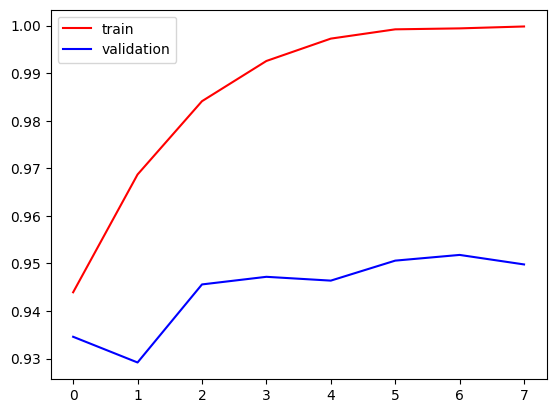

In [77]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

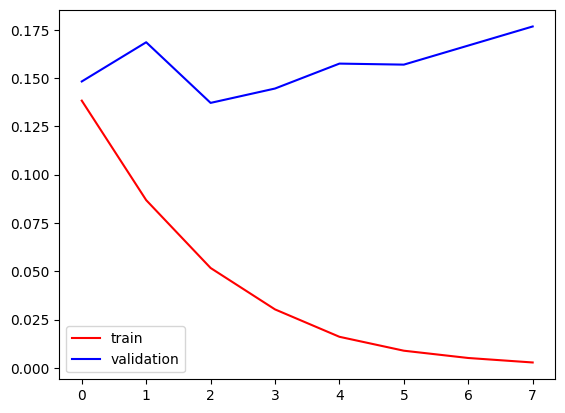

In [78]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [80]:
import cv2

In [83]:
test_img = cv2.imread('/content/dog2.jpg')

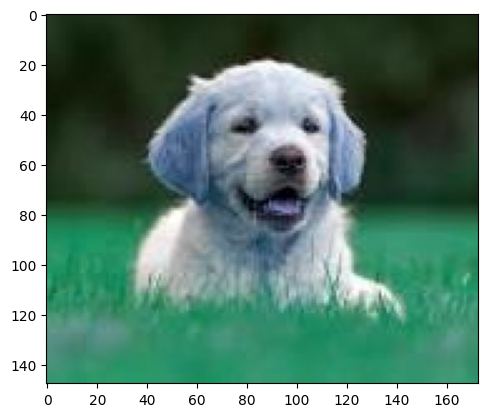

In [84]:
plt.imshow(test_img)

In [85]:
test_img.shape

(148, 173, 3)

In [86]:
test_img = cv2.resize(test_img, (150,150))

In [87]:
test_input = test_img.reshape((1,150,150,3))

In [88]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.]], dtype=float32)

In [89]:
test_img2 = cv2.imread('/content/cat.jpg')

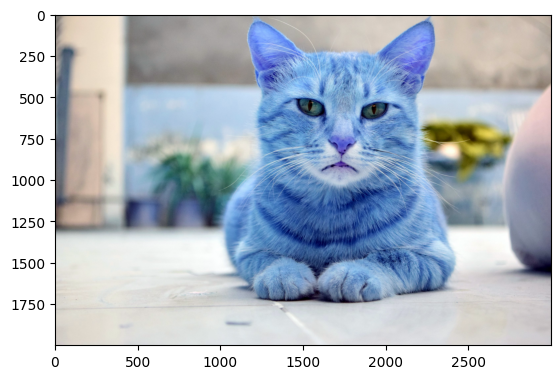

In [90]:
plt.imshow(test_img2)

In [91]:
test_img2.shape

(2000, 3000, 3)

In [92]:
test_img2 = cv2.resize(test_img2, (150,150))

In [93]:
test_input2 = test_img2.reshape((1,150,150,3))

In [94]:
model.predict(test_input2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[0.]], dtype=float32)